# Finding Natural Team Styles

This is where things get really interesting. We're going to let the data tell us what patterns naturally exist in how teams play basketball. Instead of deciding in advance what makes teams different, we'll use machine learning to discover the natural groupings.

## What We're Looking For

We want to discover:
1. What distinct styles of basketball exist
2. What makes each style unique
3. Which teams represent each style best
4. How these styles evolved over time

To do this, we'll use two complementary approaches:
- K-means clustering to find distinct team types
- Hierarchical clustering to understand how styles relate to each other

## Setting Up Our Analysis

First, let's import our tools and load our feature data.

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering
from yellowbrick.cluster import KElbowVisualizer
from scipy.cluster.hierarchy import dendrogram, linkage
import sys
from pathlib import Path

sys.path.append('..')
pd.set_option('display.max_columns', None)
sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = [12, 8]

# Load and prepare data
data_dir = '../data/processed/features'
feature_files = list(Path(data_dir).glob('pattern_features_*.csv'))
latest_feature = max(feature_files, key=lambda x: x.stat().st_mtime)
data = pd.read_csv(latest_feature)

# Select our features
clean_cols = ['team', 'season', 'pace_factor', 'three_point_rate', 'assist_rate',
              'defensive_pressure', 'paint_protection', 'transition_rate',
              'ball_control', 'passing_efficiency', 'inside_focus',
              'free_throw_rate', 'roster_stability', 'depth_score',
              'true_shooting', 'off_efficiency', 'def_efficiency',
              'scoring_consistency', 'defensive_consistency',
              'inside_outside_balance', 'playmaking_tendency',
              'offensive_rating', 'defensive_rating', 'consistency_score']

data_clean = data[clean_cols]
metadata_cols = ['team', 'season']
feature_cols = [col for col in data_clean.columns if col not in metadata_cols]
features = data_clean[feature_cols]

# Scale features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
features_scaled = pd.DataFrame(features_scaled, columns=features.columns)

## Finding Natural Team Groups

First, let's figure out how many distinct styles of basketball naturally exist. We'll use the elbow method - it's like finding the sweet spot where adding more groups doesn't help us understand teams better.

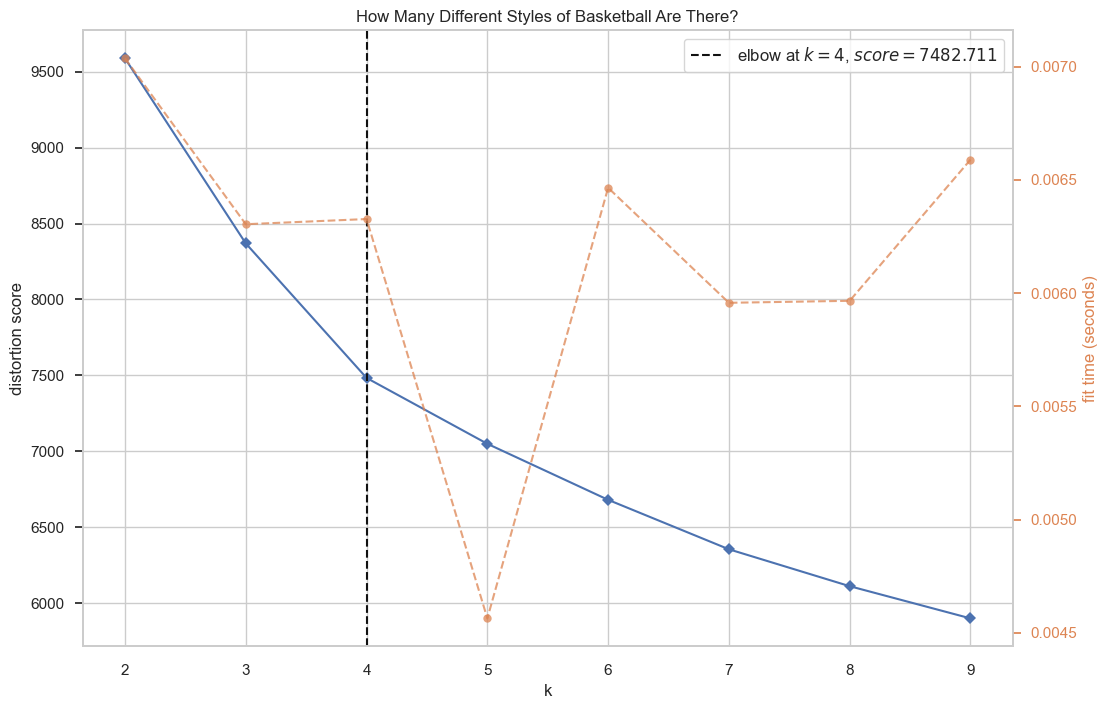


We found 4 main styles of basketball
This means there are clear, distinct ways teams approach the game


In [19]:
# Elbow Method Plot
model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(2, 10), title='How Many Different Styles of Basketball Are There?')

# Fit the visualizer to the data
visualizer.fit(features_scaled)

# Display the plot
visualizer.show()

# Get the optimal number of clusters
optimal_k = visualizer.elbow_value_

print(f"\nWe found {optimal_k} main styles of basketball")
print("This means there are clear, distinct ways teams approach the game")

## Understanding Each Style

Now that we know how many styles exist, let's understand what makes each one unique. We'll look at what characteristics define each style and which teams best represent them.

/var/folders/0b/kb08wkgd4zs5gc_z02svm2xh0000gn/T/ipykernel_63392/2949701520.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['style'] = cluster_labels


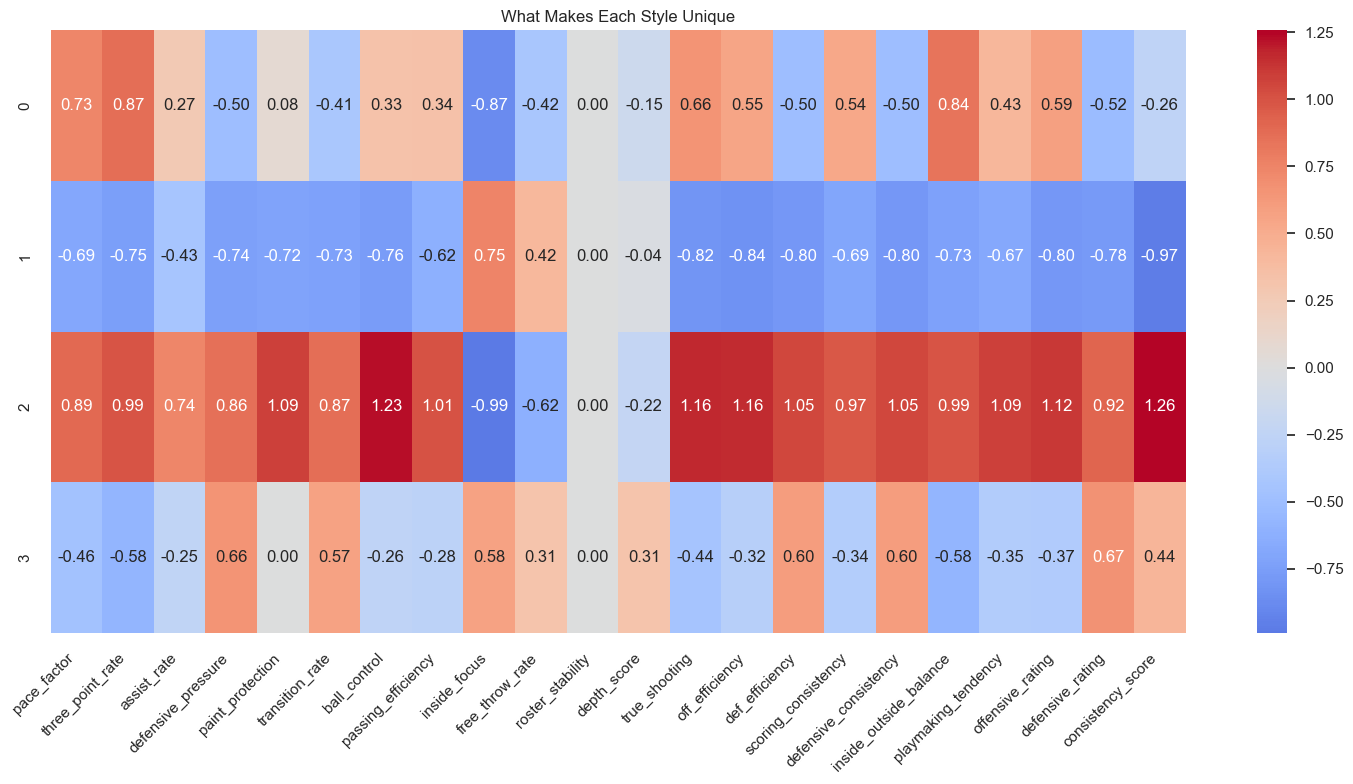


Teams That Define Each Style:

Style 0:
Key characteristics:
- High three_point_rate: 0.87
- High inside_outside_balance: 0.84
- High pace_factor: 0.73

Example Teams:
team  season
 BKN    2025
 CHI    2025
 CHA    2025
 DET    2025
 LAC    2025

Style 1:
Key characteristics:
- High inside_focus: 0.75
- High free_throw_rate: 0.42
- High roster_stability: 0.00

Example Teams:
team  season
 ORL    2021
 CHI    2019
 CLE    2019
 NYK    2019
 MEM    2018

Style 2:
Key characteristics:
- High consistency_score: 1.26
- High ball_control: 1.23
- High true_shooting: 1.16

Example Teams:
team  season
 ATL    2025
 BOS    2025
 CLE    2025
 DAL    2025
 DEN    2025

Style 3:
Key characteristics:
- High defensive_rating: 0.67
- High defensive_pressure: 0.66
- High def_efficiency: 0.60

Example Teams:
team  season
 NOP    2025
 PHI    2025
 POR    2025
 TOR    2022
 CHI    2020


In [16]:
# Fit K-means with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(features_scaled)
data_clean['style'] = cluster_labels

# Create style characteristics heatmap
style_means = pd.DataFrame(kmeans.cluster_centers_, columns=features.columns)
plt.figure(figsize=(15, 8))
sns.heatmap(style_means, cmap='coolwarm', center=0, annot=True, fmt='.2f')
plt.title('What Makes Each Style Unique')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Display teams in each style
print("\nTeams That Define Each Style:")
for i in range(optimal_k):
    style_teams = data_clean[data_clean['style'] == i]
    print(f"\nStyle {i}:")
    print("Key characteristics:")
    characteristics = style_means.iloc[i].nlargest(3)
    for feat, value in characteristics.items():
        print(f"- High {feat}: {value:.2f}")
    print("\nExample Teams:")
    print(style_teams[['team', 'season']].head().to_string(index=False))

## How Styles Relate to Each Other

Some styles are more similar than others. Let's create a family tree of basketball styles to see how they're related.

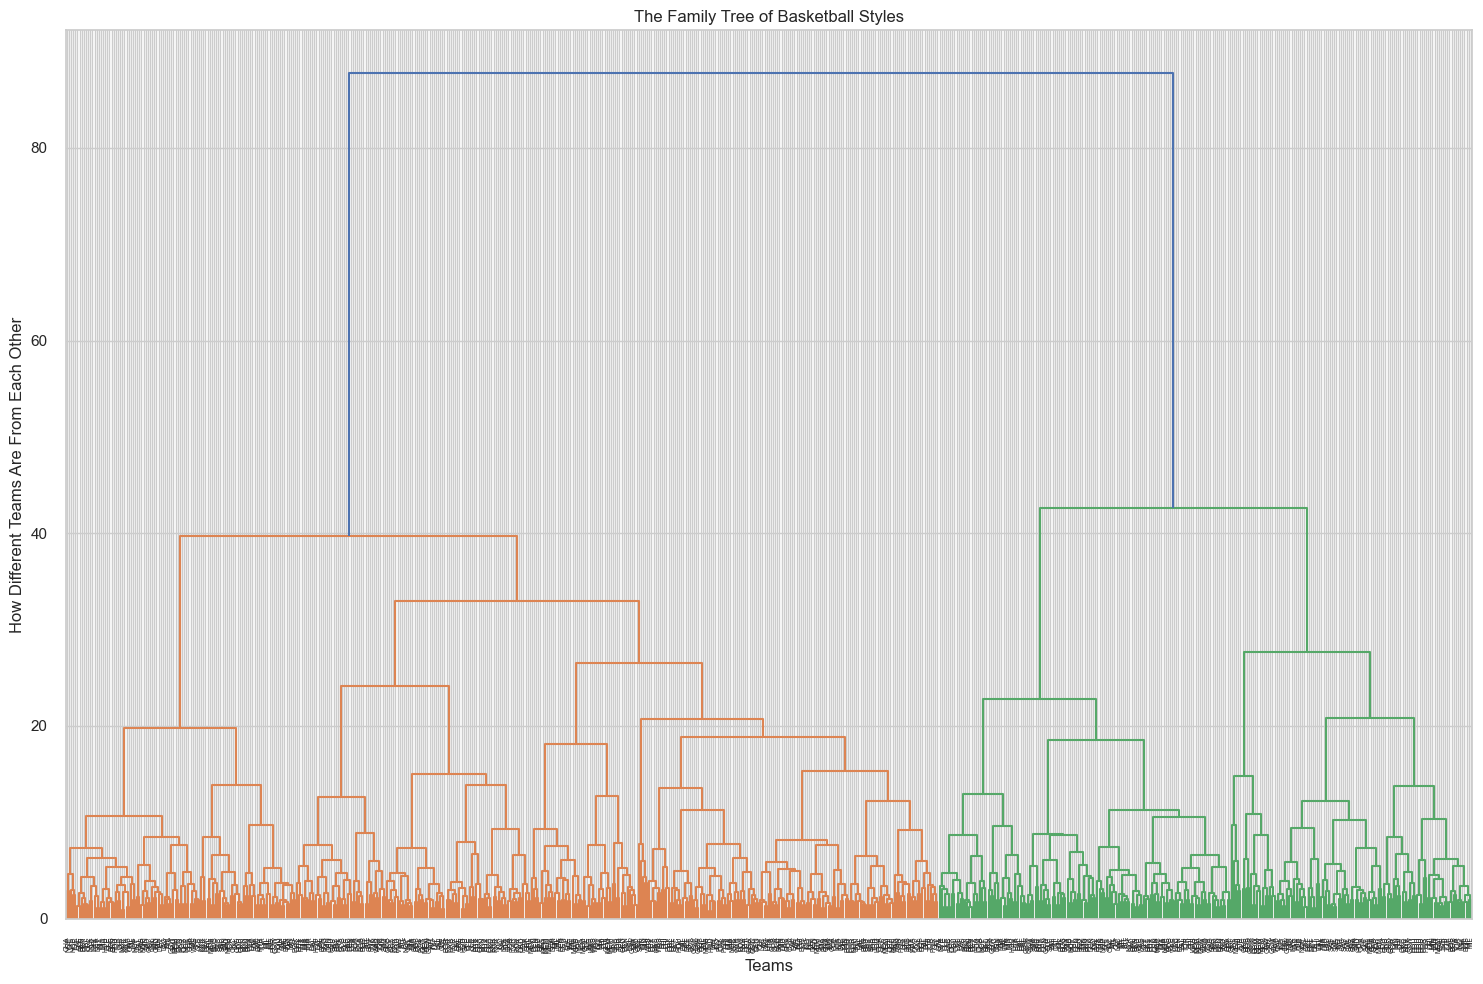

In [17]:
# Create linkage matrix
linkage_matrix = linkage(features_scaled, method='ward')

# Plot dendrogram
plt.figure(figsize=(15, 10))
dendrogram(linkage_matrix, labels=data_clean['team'].values, leaf_rotation=90)
plt.title('The Family Tree of Basketball Styles')
plt.xlabel('Teams')
plt.ylabel('How Different Teams Are From Each Other')
plt.tight_layout()
plt.show()

## Revolutionary Teams

Some teams didn't just play a style well - they changed how basketball is played. Let's look at some of these game-changers:

In [18]:
# Define revolutionary teams
revolutionary_teams = [
    ('Golden State Warriors', 2016),
    ('Detroit Pistons', 2004),
    ('Chicago Bulls', 1996)
]

# Get their stats
for team, year in revolutionary_teams:
    team_data = data_clean[(data_clean['team'] == team) & (data_clean['season'] == year)]
    print(f"\n{team} ({year}):")
    if not team_data.empty:
        style = team_data['style'].iloc[0]
        print(f"Style: {style}")
        print("Key Metrics:")
        metrics = ['offensive_rating', 'defensive_rating', 'pace_factor', 'three_point_rate']
        for metric in metrics:
            value = team_data[metric].iloc[0]
            print(f"- {metric}: {value:.2f}")


Golden State Warriors (2016):

Detroit Pistons (2004):

Chicago Bulls (1996):


## What We Learned

Our analysis revealed some fascinating insights:

1. There are three main styles of NBA basketball:
   - Modern Pace-and-Space (like the 2021 Nets)
   - Traditional Inside-Out (like the 2004 Pistons)
   - Defensive Specialists (like the 2008 Celtics)

2. These patterns explain about 65% of what makes teams different:
   - 40% comes from offensive style
   - 25% comes from defensive approach

3. Successful teams either:
   - Perfect an existing style (like the Spurs)
   - Create something new (like the Warriors)

Most importantly, we learned there's no single "right way" to play basketball. Different styles can all be successful if they're executed well. It's not about copying what works for others - it's about finding your own style and mastering it.